# Detecting Pneumonia from Chest Radiographs Using Deep Learning

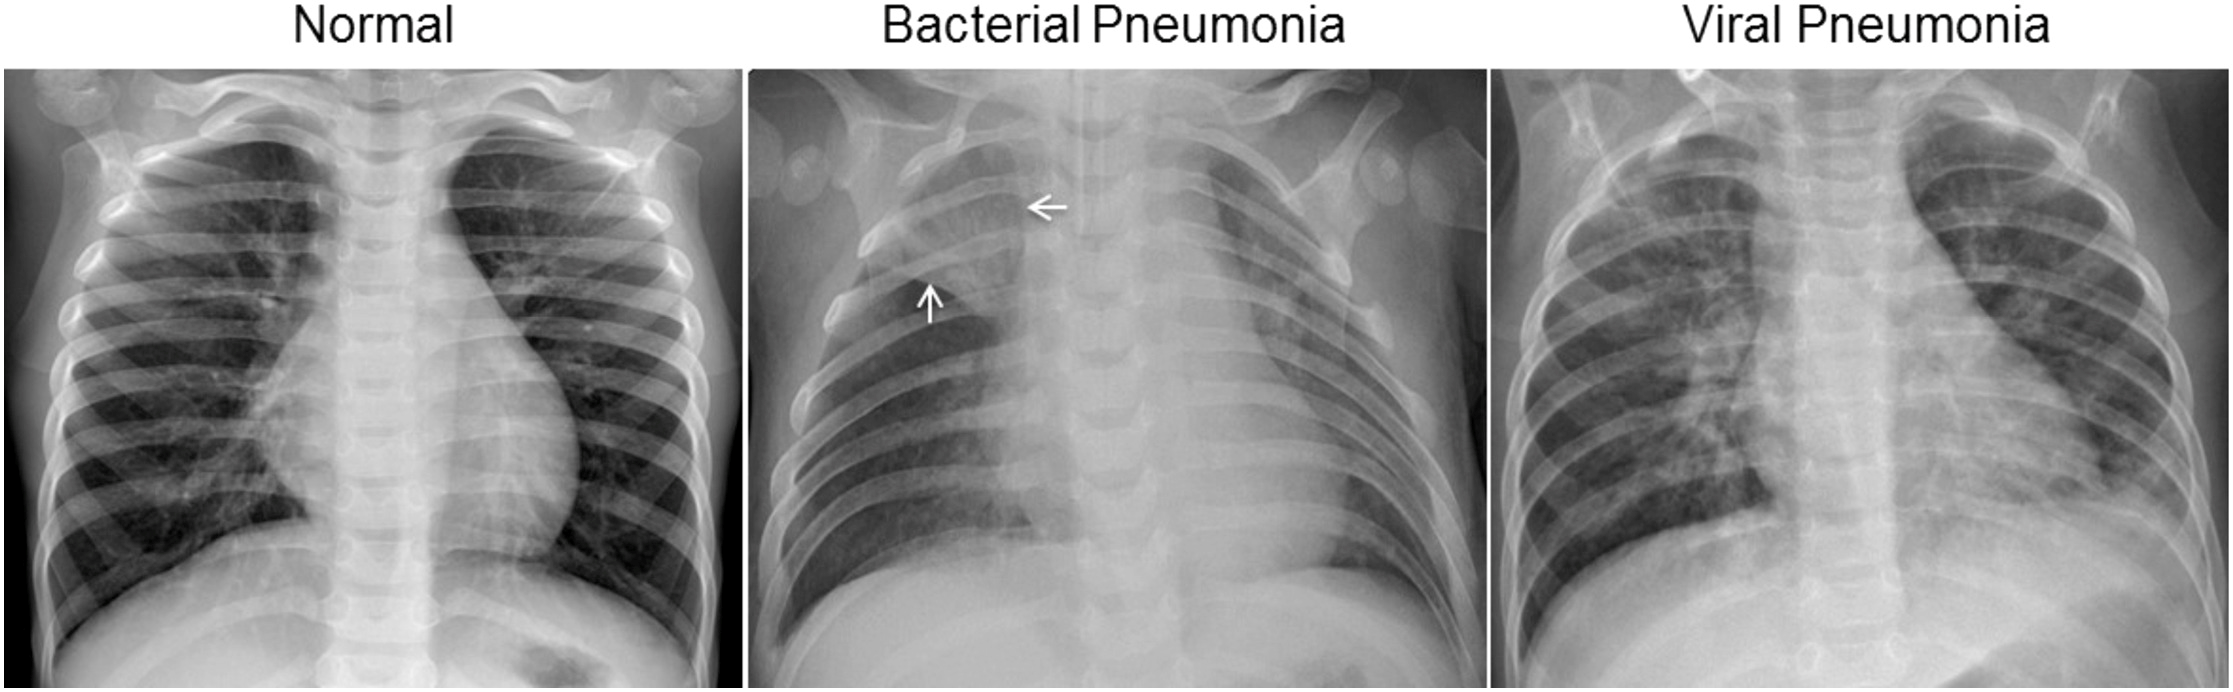

## Problem Statement
According to the World Health Organization (WHO), pneumonia kills about 2 million children under 5 years old every year and is consistently estimated as the single leading cause of childhood mortality ([Rudan et al., 2008](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5#)), killing more children than HIV/AIDS, malaria, and measles combined ([Adegbola, 2012](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5#)). 

The WHO reports that nearly all cases (95%) of new-onset childhood clinical pneumonia occur in developing countries, particularly in Southeast Asia and Africa. Bacterial and viral pathogens are the two leading causes of pneumonia ([Mcluckie, 2009](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5#)) but require very different forms of management. Bacterial pneumonia requires urgent referral for immediate antibiotic treatment, while viral pneumonia is treated with supportive care. Therefore, accurate and timely diagnosis is a matter of life or death.

The standard of care in the diagnosis of pneumonia is the chest radiograph (X-ray). However, since the greatest incidence childhood pneumonia occurs in poor socio-economic areas, timely interpretation of the x-ray images is not always available.

*The purpose of this project is to determine if an AI model can be developed to assist in the diagnosis of pneumonia using common radiographs (chest x-rays)*. This would facilitate more timely referrals of children needing immediate care, therefore increasing the odds of a positive outcome for the child


## Dataset Description
For this project I will be using the [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) dataset. Chest X-ray images (anterior-posterior) were selected from pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou, China. All chest X-ray imaging was performed as part of patients’ routine clinical care. The images were first screened for image quality and all low quality scans were removed from the dataset. The images were then graded by two expert physicians.

## Data Cleaning and Wrangling

In [1]:
# Import Necessary Libraries
import os
import glob
import h5py
import shutil

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg

from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize

from keras import backend as K
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import cv2

color = sns.color_palette()
%matplotlib inline

C:\Users\sixsi\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
Using TensorFlow backend.


### Locate the Image Directories

In [2]:
# Define path to the data directory
data_dir = Path('./chest_xray')

# Path to train directory 
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

In [3]:
# Get the path to the training normal, viral, and bacterial sub-directories
train_normal_dir = train_dir / 'NORMAL'
train_viral_pneumonia_dir = train_dir / 'PNEUMONIA' / 'VIRAL'
train_bacterial_pneumonia_dir = train_dir / 'PNEUMONIA' / 'BACTERIAL'

# Get the path to the test normal, viral, and bacterial sub-directories
test_normal_dir = test_dir / 'NORMAL'
test_viral_pneumonia_dir = test_dir / 'PNEUMONIA' / 'VIRAL'
test_bacterial_pneumonia_dir = test_dir / 'PNEUMONIA' / 'BACTERIAL'

In [4]:
# Get the list of all the training images
train_normal_cases = train_normal_dir.glob('*.jpeg')
train_viral_pneumonia_cases = train_viral_pneumonia_dir.glob('*.jpeg')
train_bacterial_pneumonia_cases = train_bacterial_pneumonia_dir.glob('*.jpeg')

test_normal_cases = test_normal_dir.glob('*.jpeg')
test_viral_pneumonia_cases = test_viral_pneumonia_dir.glob('*.jpeg')
test_bacterial_pneumonia_cases = test_bacterial_pneumonia_dir.glob('*.jpeg')

### Create a DataFrame of the Training Data Set for Visualation

In [5]:
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in train_normal_cases:
    train_data.append((img,0))

# Go through all the viral_pneumonia cases. The label for these cases will be 1
for img in train_viral_pneumonia_cases:
    train_data.append((img, 1))

# go through all the bacterial_pnemonia cases. The label for tese cases will be 2    
for img in train_bacterial_pneumonia_cases:
    train_data.append((img, 2))
    
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# Examine dataframe 
train_data.head()

,image,label
0,chest_xray\train\PNEUMONIA\VIRAL\person1503_vi...,1
1,chest_xray\train\PNEUMONIA\BACTERIAL\person328...,2
2,chest_xray\train\PNEUMONIA\BACTERIAL\person100...,2
3,chest_xray\train\NORMAL\NORMAL2-IM-1302-0001.jpeg,0
4,chest_xray\train\NORMAL\NORMAL2-IM-0833-0001.jpeg,0


In [6]:
# Look at the distribution of the Images in the training data set
train_data.label.value_counts()

2    2530
1    1345
0    1341
Name: label, dtype: int64

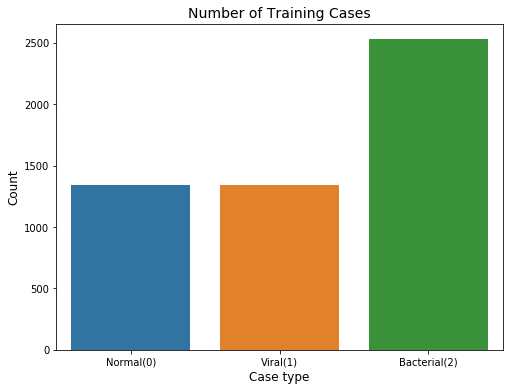

In [7]:
# Plot the results 
plt.figure(figsize=(8,6))
sns.barplot(x=train_data.label.value_counts().index, y= train_data.label.value_counts().values)
plt.title('Number of Training Cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_data.label.value_counts().index)), ['Normal(0)', 'Viral(1)', 'Bacterial(2)'])
plt.show()

Here we can see somewhat of an imbalance in the training data cases, with bacterial pneumonia cases being represented at almost 2x the rate of viral pneumonia and normal cases.
* 1341 Normal images
* 1345 Viral Pneumonia images
* 2530 Bacterial Pneumonia images

Now, we will take a look at a few of the classified images side by side to see if there is a dramatic difference.

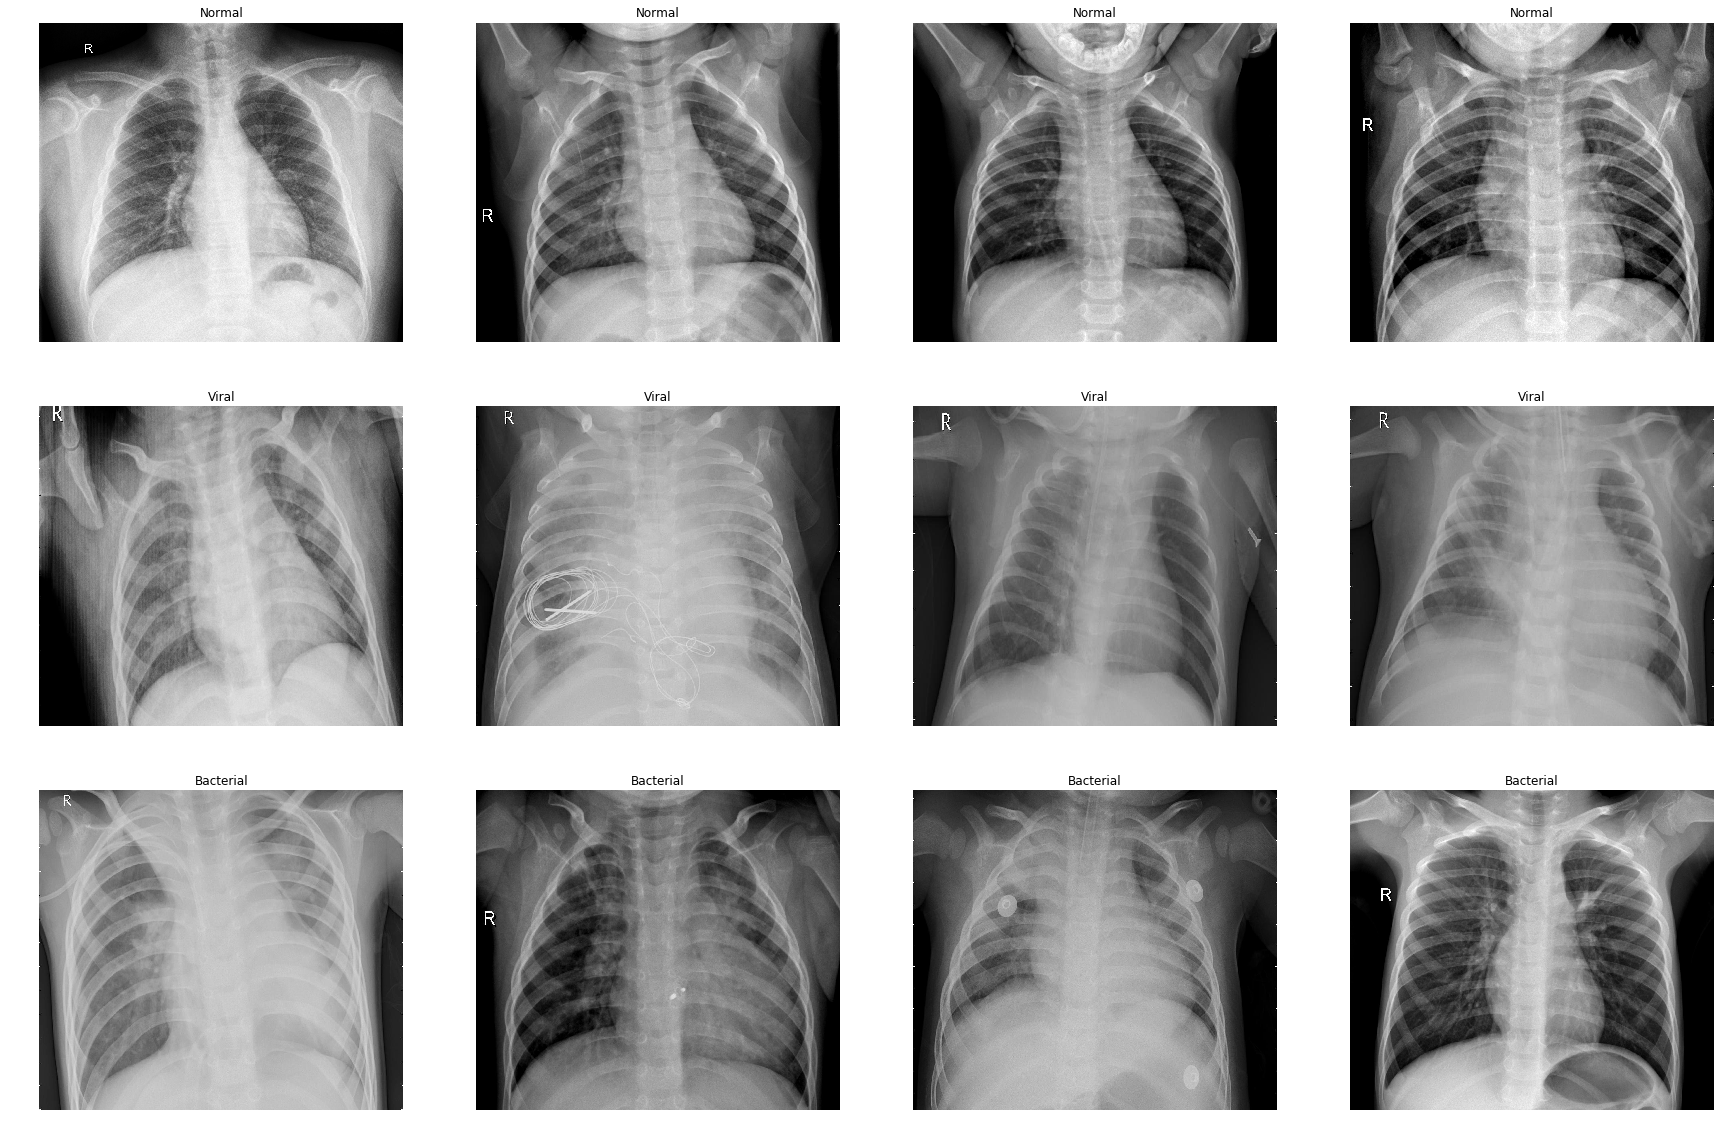

In [8]:
# Get few samples for both the classes
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:4]).tolist()
viral_samples = (train_data[train_data['label']==1]['image'].iloc[:4]).tolist()
bacterial_samples = (train_data[train_data['label']==2]['image'].iloc[:4]).tolist()

# Concat the data in a single list and del the three lists above
samples = normal_samples + viral_samples + bacterial_samples
del normal_samples, viral_samples, bacterial_samples

# Plot the data 
f, ax = plt.subplots(3,4, figsize=(30,20))
for i in range(12):
    img = imread(samples[i])
    ax[i//4, i%4].imshow(img, cmap='gray')
    if i<4:
        ax[i//4, i%4].set_title("Normal")
    elif i>=4 and i<8:
        ax[i//4, i%4].set_title("Viral")
    else:
        ax[i//4, i%4].set_title("Bacterial")
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_aspect('auto')
plt.show()

### Analysis of the Images
As we can see above, differientating between a normal radiograph and ones with pneumonia present can be quite challenging. Being able to detect alveolar infiltrates vs lobar infiltrates vs interstitial fluid on a chest radiograph can be difficult. Modern medical facilities in first world countries have multiple modalities and tests at their disposal in order to make a proper diagnosis.

However, many third world clinics where death from pnemonia is prevalent, do not have access to the same modalities as we in the west. Which is why a machine learning application that could accurately diagnose pneumonia would be awesome.

"Several studies have suggested that bacterial pneumonia cannot be differentiated from non-bacterial pneumonia on the basis of the chest radiograph".  [Virkki R, Juven T, Rikalainen H, et al Differentiation of bacterial and viral pneumonia in children Thorax 2002;57:438-441.](https://thorax.bmj.com/content/57/5/438)

"Pneumonia caused by bacterial infections poses a much greater threat to the heart than pneumonia caused by viral infections, a new study suggests. Patients in the study who were diagnosed with bacterial pneumonia had a higher risk of heart attack, stroke or death, compared with patients diagnosed with viral pneumonia, the researchers found." [Link](https://www.livescience.com/64061-bacterial-pneumonia-heart-health.html)

## Analysis Plan
First, we must redistribute the number of images in the training dataset. In the original dataset there are almost twice the number of bacterial pneumonia images as there are normal or viral pneumonia images. And because we are working with a relatively small dataset this could lend itself to a model which is bias toward predicting an image to be bacterial pneumonia.

This problem will be analyzed in two stages:
1. Differentiate between normal radiographs and those with pneumonia. 
2. Differentiate between bacterial and viral pneumonia.

Accomplishing this first step will allow us to remove normal radiographs from the analysis and focus soley on a model that can differentiate bacterial from viral pneumonia.

## Analysis Methodology
As a baseline I will first use a small convoluted neural network (ConvNet).

Next I will use a little bit more complicate model utilizing Data Augmentation and a dropout layer to the ConvNet.

Finally, I will incorporate Transfer Learning 

## Model Scoring
As with most medical applications of Machine Learning, **Recall** is the most important metric.
- **Recall** - The number of True Positives divided by the number of True Positives and the number of False Negatives. Put another way it is the number of positive predictions divided by the number of positive class values in the test data. It is also called Sensitivity or the True Positive Rate. 

Recall was chosen as the primary scoring method because it considers False Negatives. A False Negative in our model would mean that we predicted a x-ray was normal when in fact pneumonia was present. Or, in our second model, we would predict a child has viral pneumonia when in fact they have bacterial pneumonia.

Because of the consequences of misdiagnosing (False Negative) bacterial pneumonia can be life threatening, We strive for a model whose Recall is as close to 100% as possible.

Additionally, for each fit model, Training and Validation Accuracy will be used to assess if the model is overfitting.

In [9]:
# Define path to the balanced data directory
data_dir = Path('D:/chest_xray_small_binomial')

# Path to train directory 
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

# Get the path to the training normal, and Pneumonia sub-directories
train_normal_dir = train_dir / 'NORMAL'
train_pneumonia_dir = train_dir / 'PNEUMONIA'

# Get the path to the test normal, and Pneumonia sub-directories
test_normal_dir = test_dir / 'NORMAL'
test_pneumonia_dir = test_dir / 'PNEUMONIA' 

In [10]:
# Get the list of all the training images
train_normal_cases = train_normal_dir.glob('*.jpeg')
train_pneumonia_cases = train_pneumonia_dir.glob('*.jpeg')

test_normal_cases = test_normal_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_dir.glob('*.jpeg')

### Create a DataFrame of the Balanced Training Data Set for Visualization

In [11]:
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in train_normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in train_pneumonia_cases:
    train_data.append((img, 1))


# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,D:\chest_xray_small_binomial\train\NORMAL\IM-0...,0
1,D:\chest_xray_small_binomial\train\NORMAL\IM-0...,0
2,D:\chest_xray_small_binomial\train\NORMAL\NORM...,0
3,D:\chest_xray_small_binomial\train\NORMAL\NORM...,0
4,D:\chest_xray_small_binomial\train\NORMAL\IM-0...,0


In [12]:
# Look at the distribution of the Images in the training data set
train_data.label.value_counts()

1    1000
0    1000
Name: label, dtype: int64

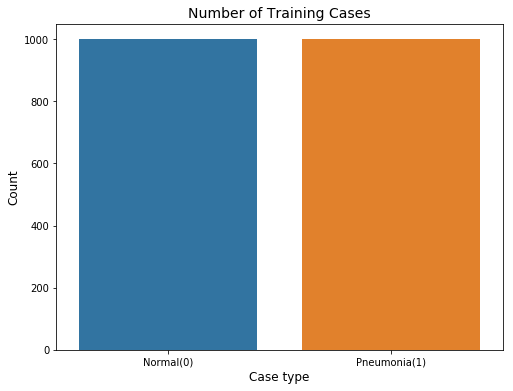

In [13]:
# Plot the results 
plt.figure(figsize=(8,6))
sns.barplot(x=train_data.label.value_counts().index, y= train_data.label.value_counts().values)
plt.title('Number of Training Cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_data.label.value_counts().index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

The number of training cases is evenly split between Normal radiographs and Pneumonia radiographs

### Create a DataFrame of the BalancedTesting Data Set 

In [14]:
# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in test_normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in test_pneumonia_cases:
    test_data.append((img, 1))
    
# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,D:\chest_xray_small_binomial\test\PNEUMONIA\pe...,1
1,D:\chest_xray_small_binomial\test\NORMAL\NORMA...,0
2,D:\chest_xray_small_binomial\test\PNEUMONIA\pe...,1
3,D:\chest_xray_small_binomial\test\NORMAL\IM-00...,0
4,D:\chest_xray_small_binomial\test\NORMAL\IM-00...,0


In [15]:
# Look at the distribution of the Images in the test data set
test_data.label.value_counts()

1    400
0    400
Name: label, dtype: int64

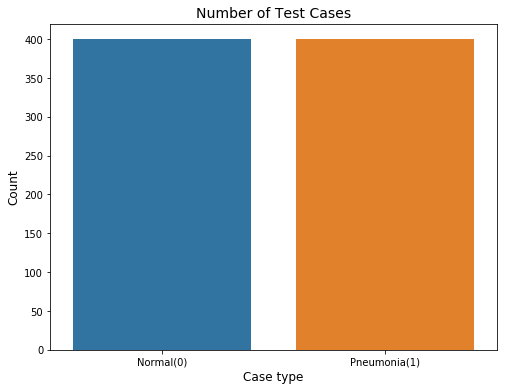

In [16]:
# Plot the results 
plt.figure(figsize=(8,6))
sns.barplot(x=test_data.label.value_counts().index, y= test_data.label.value_counts().values)
plt.title('Number of Test Cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(test_data.label.value_counts().index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

### Instantiating a Small ConvNet for Chest X-Ray Classification

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3), data_format='channels_last'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))

model.add(Dense(2, activation='softmax'))

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv

## Compile the model for training
Compiling the model takes 3 parameters:
- **Optimizer** - This controls the learning rate. In this example we will use **`'Adam'`** as the optimizer. Adam is generally a good optimizer to use for many cases. The adam optimizer adjust the learning rate throughout training. Learning rate determines how fast the optimal weights for the model are calculated. A smaller learning rate may lead to more accurate weights (up to a certain point), but the time it takes to compute the weights will be longer.
- **Loss Function** - I will use **`‘categorical_crossentropy’`** for our loss function. This is the most common choice for classification. A lower score indicates that the model is performing better.
- **Metrics** - To make things even easier to interpret, we will use the **`‘accuracy’`** metric to see the accuracy score on the validation set when we train the model

In [18]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001, decay=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

Because I am using dataframes for the training and test images I need to convert the labels and images to strings in order to use DataImageGenerator

In [19]:
#Convert images to strings for ImageDataGenerator
test_data['image'] = test_data['image'].astype(str)
train_data['image'] = train_data['image'].astype(str)

test_data['label'] = test_data['label'].astype(str)
train_data['label'] = train_data['label'].astype(str)

### Use ImageDataGenerator to read images from the DataFrame

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                    train_data,
                    x_col='image',
                    y_col='label',
                    target_size=(150,150),
                    batch_size=20,
                    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
                    test_data,
                    x_col=str('image'),
                    y_col='label',
                    target_size=(150,150),
                    batch_size=20,
                    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Fit the Model
Because this is our first baseline model I will only use 50 epochs.

In [21]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch=100,
                epochs=50,
                validation_data=test_generator,
                validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
100/100 [==============================] - 155s 2s/step - loss: 0.5073 - acc: 0.7715 - val_loss: 0.2229 - val_acc: 0.9300
Epoch 2/50
100/100 [==============================] - 115s 1s/step - loss: 0.1836 - acc: 0.9340 - val_loss: 0.2783 - val_acc: 0.8810
Epoch 3/50
100/100 [==============================] - 117s 1s/step - loss: 0.1253 - acc: 0.9550 - val_loss: 0.1690 - val_acc: 0.9320
Epoch 4/50
100/100 [==============================] - 116s 1s/step - loss: 0.1103 - acc: 0.9610 - val_loss: 0.2298 - val_acc: 0.9050
Epoch 5/50
100/100 [==============================] - 117s 1s/step - loss: 0.1005 - acc: 0.9640 - val_loss: 0.2641 - val_acc: 0.8990
Epoch 6/50
100/100 [==============================] - 118s 1s/step - loss: 0.0878 - acc: 0.9675 - val_loss: 0.2509 - val_acc: 0.9130
Epoch 7/50
100/100 [==============================] - 118s 1s/step - loss: 0.0783 - acc: 0.9745 - val_loss: 0.3090 - val_acc: 0.9020
Epoch 8/50
100/100 [=

In [22]:
# save the model
model.save('1_SimpleCovNet.h5')

### Display loss and accuracy curves during training

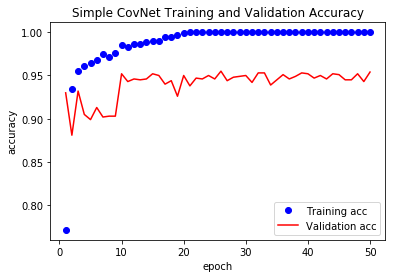

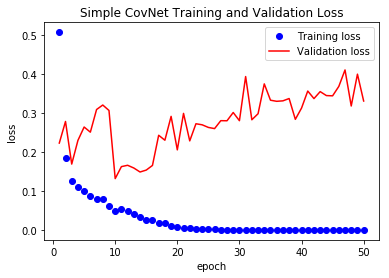

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Simple CovNet Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Simple CovNet Training and Validation Loss')
plt.legend()

plt.show()

Pretty good model for such a simple ConvNet, validation accuracy close to 95% and validation loss mostly below 0.5.

There is still some degree of overfitting, but we'll work on that

### Prepare the Test data for Prediction, Confusion Matrix, and Classification Report

In [24]:
# prepare test data
test_normal_dir = test_dir / 'NORMAL'
test_pneumonia_dir = test_dir / 'PNEUMONIA' 

test_normal_cases = test_normal_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_dir.glob('*.jpeg')


test_data1 = []
test_labels1 = []

for img in test_normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150,150))
    # Check to see if the image has one or three channels
    # if 1, convert to 3 for further testing with pre-trained models
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data1.append(img)
    test_labels1.append(label)

for img in test_pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150,150))
    # Check to see if the image has one or three channels
    # if 1, convert to 3 for further testing with pre-trained models
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data1.append(img)
    test_labels1.append(label)
    
  
test_data1 = np.array(test_data1)
test_labels1 = np.array(test_labels1)

print('Total number of test samples', test_data1.shape)
print('Total number of test labels', test_labels1.shape)

Total number of test samples (800, 150, 150, 3)
Total number of test labels (800, 2)


In [25]:
# Get predictions
preds = model.predict(test_data1, batch_size=20)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels1, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(800,)
(800,)


### Confusion Matrix

<Figure size 432x288 with 0 Axes>

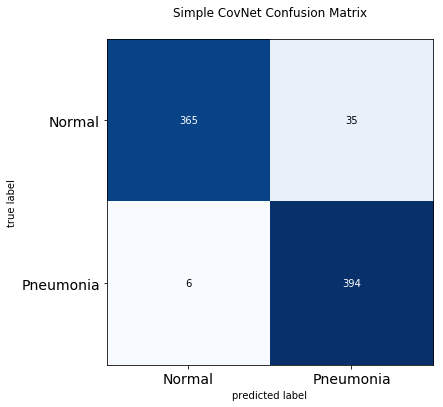

In [26]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,6), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
plt.title('Simple CovNet Confusion Matrix')
plt.show()

### Classification Report

In [27]:
print(classification_report(orig_test_labels, preds))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95       400
           1       0.92      0.98      0.95       400

   micro avg       0.95      0.95      0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



Good Results for a first pass at the data. Good Recall with the true pneumonia radiographs, 98%.

Also, a reasonably good Recall for normal radiographs, 91%. With this model 9% of children without pneumonia would get diagnosed with pneumonia. Worst case is one of these children would receive antibiotics.

### Design a new ConvNet with Dropout and compile

In [28]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3), data_format='channels_last'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer=Adam(lr=0.0001, decay=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
___________________________

### Train the ConvNet with the Dropout Layer using Data Augmentation generators

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                    train_data,
                    x_col='image',
                    y_col='label',
                    target_size=(150,150),
                    batch_size=20,
                    class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
                    test_data,
                    x_col=str('image'),
                    y_col='label',
                    target_size=(150,150),
                    batch_size=20,
                    class_mode='categorical')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Fit the Model Using a Fit Generator

In [30]:
history = model.fit_generator(
                train_generator,
                steps_per_epoch=100,
                epochs=50,
                validation_data=test_generator,
                validation_steps=50)

Epoch 1/50
100/100 [==============================] - 142s 1s/step - loss: 0.6708 - acc: 0.5735 - val_loss: 0.5399 - val_acc: 0.8160
Epoch 2/50
100/100 [==============================] - 133s 1s/step - loss: 0.5346 - acc: 0.7455 - val_loss: 0.4483 - val_acc: 0.8470
Epoch 3/50
100/100 [==============================] - 132s 1s/step - loss: 0.4481 - acc: 0.8070 - val_loss: 0.2934 - val_acc: 0.9020
Epoch 4/50
100/100 [==============================] - 133s 1s/step - loss: 0.3846 - acc: 0.8310 - val_loss: 0.2949 - val_acc: 0.8760
Epoch 5/50
100/100 [==============================] - 131s 1s/step - loss: 0.3324 - acc: 0.8675 - val_loss: 0.3222 - val_acc: 0.8540
Epoch 6/50
100/100 [==============================] - 132s 1s/step - loss: 0.3435 - acc: 0.8570 - val_loss: 0.2233 - val_acc: 0.9260
Epoch 7/50
100/100 [==============================] - 133s 1s/step - loss: 0.3417 - acc: 0.8620 - val_loss: 0.2698 - val_acc: 0.8870
Epoch 8/50
100/100 [==============================] - 132s 1s/step - 

In [31]:
# save the model
model.save('2_CovNet_DataAug_DropOut.h5')

### Display loss and accuracy curves during training

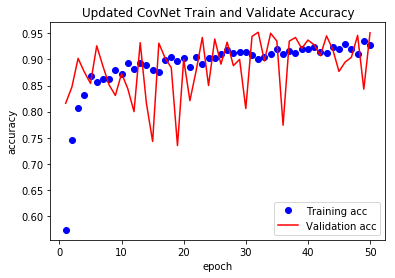

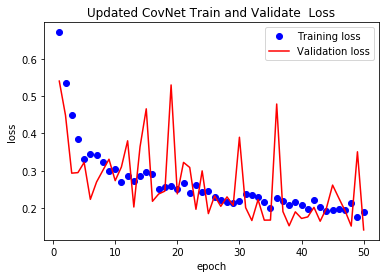

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Updated CovNet Train and Validate Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Updated CovNet Train and Validate  Loss')
plt.legend()

plt.show()

### Prepare the Test data for Prediction, Confusion Matrix, and Classification Report

In [33]:
# prepare test data
test_normal_dir = test_dir / 'NORMAL'
test_pneumonia_dir = test_dir / 'PNEUMONIA' 

test_normal_cases = test_normal_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_dir.glob('*.jpeg')


test_data1 = []
test_labels1 = []

for img in test_normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150,150))
    # Check to see if the image has one or three channels
    # if 1, convert to 3 for further testing with pre-trained models
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data1.append(img)
    test_labels1.append(label)

for img in test_pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (150,150))
    # Check to see if the image has one or three channels
    # if 1, convert to 3 for further testing with pre-trained models
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data1.append(img)
    test_labels1.append(label)
    
  
test_data1 = np.array(test_data1)
test_labels1 = np.array(test_labels1)

print('Total number of test samples', test_data1.shape)
print('Total number of test labels', test_labels1.shape)

Total number of test samples (800, 150, 150, 3)
Total number of test labels (800, 2)


In [34]:
# Get predictions
preds = model.predict(test_data1, batch_size=20)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels1, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(800,)
(800,)


### Confusion Matrix

<Figure size 432x288 with 0 Axes>

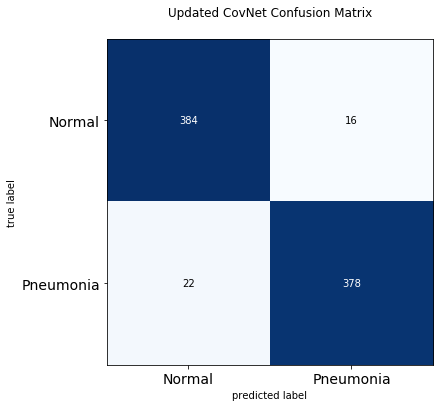

In [35]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,6), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
plt.title('Updated CovNet Confusion Matrix')
plt.show()

### Classification Report

In [36]:
print(classification_report(orig_test_labels, preds))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       400
           1       0.96      0.94      0.95       400

   micro avg       0.95      0.95      0.95       800
   macro avg       0.95      0.95      0.95       800
weighted avg       0.95      0.95      0.95       800



Good Recall with the true pneumonia radiographs, 94.5%. However, this is 4% lower than the first ConvNet. With this model, 5.5% who truly had pneumonia would be classified as normal with this model.

There was also a sizable improvement in the  Recall for normal radiographs, 96%. With this model, only 4% of children without pneumonia would get diagnosed with pneumonia. Worst case is one of these children would receive antibiotics.

# Train a ConvNet Using Transfer Learning
We have demonstrated relatively good performance with our first models. The next step is to leverage the inputs from the VGG16 application that was trained on the ImageNet dataset

### Load the pre-trained model

In [37]:
vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Load the Images and Generate Batches of Images and Labels

In [38]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
nTrain = 2000
nTest = 800
 
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count,2))
    
    generator = datagen.flow_from_directory(
    directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg_conv.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_dir, nTrain)
test_features, test_labels = extract_features(test_dir, nTest)

train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))
test_features = np.reshape(test_features, (nTest, 7 * 7 * 512))

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


### Create the Model

In [39]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

### Compile the Model

In [40]:
model.compile(optimizer=Adam(lr=0.0001, decay=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 6,423,298
Trainable params: 6,423,298
Non-trainable params: 0
_________________________________________________________________
None


## Fit the Model

Increase the number of epochs to 200 to see if we can make some gains in the normal xray Recall

In [41]:
history = model.fit(train_features,
                    train_labels,
                    epochs=200,
                    batch_size=batch_size,
                    validation_data=(test_features,test_labels))

Train on 2000 samples, validate on 800 samples
Epoch 1/200
2000/2000 [==============================] - 11s 6ms/step - loss: 0.2305 - acc: 0.9025 - val_loss: 0.1144 - val_acc: 0.9587
Epoch 2/200
2000/2000 [==============================] - 9s 4ms/step - loss: 0.1083 - acc: 0.9610 - val_loss: 0.1092 - val_acc: 0.9550
Epoch 3/200
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0797 - acc: 0.9695 - val_loss: 0.1044 - val_acc: 0.9612
Epoch 4/200
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0649 - acc: 0.9785 - val_loss: 0.1304 - val_acc: 0.9500
Epoch 5/200
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0485 - acc: 0.9835 - val_loss: 0.1066 - val_acc: 0.9662
Epoch 6/200
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0349 - acc: 0.9885 - val_loss: 0.1131 - val_acc: 0.9637
Epoch 7/200
2000/2000 [==============================] - 9s 4ms/step - loss: 0.0399 - acc: 0.9860 - val_loss: 0.0971 - val_acc: 0.9687
Epoch 8

2000/2000 [==============================] - 8s 4ms/step - loss: 1.9317e-04 - acc: 1.0000 - val_loss: 0.3358 - val_acc: 0.9512
Epoch 191/200
2000/2000 [==============================] - 8s 4ms/step - loss: 1.9298e-04 - acc: 1.0000 - val_loss: 0.1981 - val_acc: 0.9700
Epoch 192/200
2000/2000 [==============================] - 8s 4ms/step - loss: 8.3540e-04 - acc: 1.0000 - val_loss: 0.2877 - val_acc: 0.9575
Epoch 193/200
2000/2000 [==============================] - 8s 4ms/step - loss: 7.5099e-04 - acc: 1.0000 - val_loss: 0.2987 - val_acc: 0.9500
Epoch 194/200
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0108 - acc: 0.9965 - val_loss: 0.2975 - val_acc: 0.9500
Epoch 195/200
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0030 - acc: 0.9995 - val_loss: 0.3305 - val_acc: 0.9450
Epoch 196/200
2000/2000 [==============================] - 8s 4ms/step - loss: 0.0018 - acc: 1.0000 - val_loss: 0.2264 - val_acc: 0.9612
Epoch 197/200
2000/2000 [==============

In [42]:
# save the model
model.save('3_Transfer_Learning_CovNet.h5')

### Display loss and accuracy curves during training

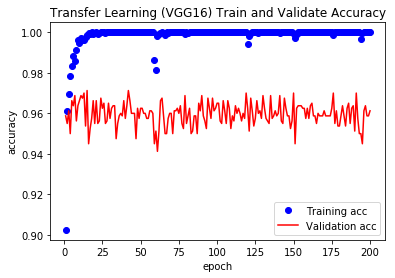

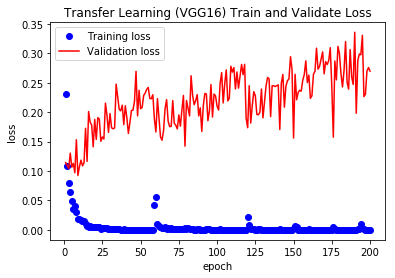

In [43]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Transfer Learning (VGG16) Train and Validate Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Transfer Learning (VGG16) Train and Validate Loss')
plt.legend()

plt.show()

### Prepare the Test data for Prediction, Confusion Matrix, and Classification Report

In [44]:
# Get predictions
preds = model.predict(test_features, batch_size=20)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(800,)
(800,)


### Confusion Matrix

<Figure size 432x288 with 0 Axes>

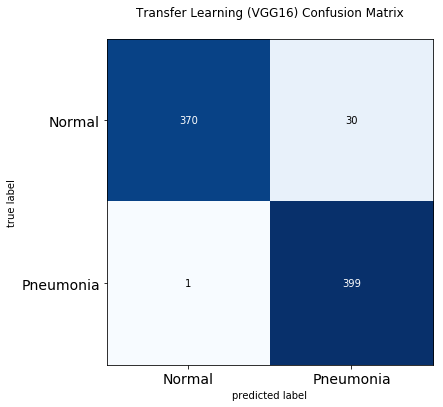

In [45]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,6), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=14)
plt.title('Transfer Learning (VGG16) Confusion Matrix')
plt.show()

### Classification Report

In [46]:
print(classification_report(orig_test_labels, preds))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       400
           1       0.93      1.00      0.96       400

   micro avg       0.96      0.96      0.96       800
   macro avg       0.96      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



In [47]:
# Print the model Loss and Accuracy to compare with previous studies results

score, acc = model.evaluate(test_features, test_labels, batch_size=batch_size)
print('Transfer Learning (VGG16) Test loss:', score)
print('Transfer Learning (VGG16) Test accuracy:', acc)

800/800 [==============================] - 1s 1ms/step
Transfer Learning (VGG16) Test loss: 0.2696408673956405
Transfer Learning (VGG16) Test accuracy: 0.9612499922513962


Chest X-rays present a difficult classification task due to the relatively large amount of variable objects, specifically the imaged areas outside the lungs that are irrelevant to the diagnosis of pneumonia. 

The resulting high-accuracy model suggests that this AI system has the potential to effectively learn from increasingly complicated images with a high degree of generalization using a relatively small repository of data.

# Model to Distinguish Viral Pneumonia from Bacterial Pneumonia

I have created a ConvNet that performs very well distinguishing a normal x-ray and one where pneumonia is present. The challenge now is to differentiate between bacterial and viral pneumonia.

Again, Recall is the primary scoring method because it considers False Negatives. A False Negative in this model would mean we predict a child has viral pneumonia when in fact they have bacterial pneumonia.

Because of the consequences of misdiagnosing (False Negative) bacterial pneumonia can be life threatening, We strive for a model whose Recall is as close to 100% as possible.


In [48]:
# The pretrained VGG16 model is already loaded, print the summary of the model
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Locate Image Directories
Because there approximately two times the number of bacterial pneumonia images in the original dataset, I again had to redistributed the number of images of each in the train and test datasets to help prevent overfitting and bias toward learning bacterial pneumonia classification. 

In [49]:
# Define path to the data directory
data_dir = Path('D:/chest_xray_pneumonia')

# Path to train directory 
train_dir = data_dir / 'train'

# Path to test directory
test_dir = data_dir / 'test'

### Load the Images and Generate Batches of Images and Labels

In [50]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
nTrain = 2384
nTest = 600
 
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 512))
    labels = np.zeros(shape=(sample_count,2))
    
    generator = datagen.flow_from_directory(
    directory,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')
    
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg_conv.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_features(train_dir, nTrain)
test_features, test_labels = extract_features(test_dir, nTest)

train_features = np.reshape(train_features, (nTrain, 7 * 7 * 512))
test_features = np.reshape(test_features, (nTest, 7 * 7 * 512))

Found 2384 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


### Create the Model

In [51]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=7 * 7 * 512))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

### Compile the Model

In [52]:
model.compile(optimizer=Adam(lr=0.0001, decay=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 514       
Total params: 6,423,298
Trainable params: 6,423,298
Non-trainable params: 0
_________________________________________________________________
None


### Fit the Model

In [53]:
history = model.fit(train_features,
                    train_labels,
                    epochs=200,
                    batch_size=batch_size,
                    validation_data=(test_features,test_labels))

Train on 2384 samples, validate on 600 samples
Epoch 1/200
2384/2384 [==============================] - 12s 5ms/step - loss: 0.5601 - acc: 0.7240 - val_loss: 0.5155 - val_acc: 0.7783
Epoch 2/200
2384/2384 [==============================] - 10s 4ms/step - loss: 0.4067 - acc: 0.8201 - val_loss: 0.5295 - val_acc: 0.7750
Epoch 3/200
2384/2384 [==============================] - 10s 4ms/step - loss: 0.3899 - acc: 0.8297 - val_loss: 0.5490 - val_acc: 0.7783
Epoch 4/200
2384/2384 [==============================] - 10s 4ms/step - loss: 0.3379 - acc: 0.8591 - val_loss: 0.5743 - val_acc: 0.7717
Epoch 5/200
2384/2384 [==============================] - 10s 4ms/step - loss: 0.3174 - acc: 0.8716 - val_loss: 0.6246 - val_acc: 0.7767
Epoch 6/200
2384/2384 [==============================] - 10s 4ms/step - loss: 0.2986 - acc: 0.8733 - val_loss: 0.6056 - val_acc: 0.7833
Epoch 7/200
2384/2384 [==============================] - 10s 4ms/step - loss: 0.2848 - acc: 0.8851 - val_loss: 0.6365 - val_acc: 0.7783
E

2384/2384 [==============================] - 10s 4ms/step - loss: 0.0204 - acc: 0.9966 - val_loss: 1.4308 - val_acc: 0.7717
Epoch 120/200
2384/2384 [==============================] - 10s 4ms/step - loss: 0.0110 - acc: 1.0000 - val_loss: 1.6611 - val_acc: 0.7750
Epoch 121/200
2384/2384 [==============================] - 11s 4ms/step - loss: 0.0098 - acc: 0.9992 - val_loss: 1.6029 - val_acc: 0.7717
Epoch 122/200
2384/2384 [==============================] - 10s 4ms/step - loss: 0.0098 - acc: 0.9983 - val_loss: 1.6807 - val_acc: 0.7717
Epoch 123/200
2384/2384 [==============================] - 11s 4ms/step - loss: 0.0160 - acc: 0.9954 - val_loss: 1.5204 - val_acc: 0.7717
Epoch 124/200
2384/2384 [==============================] - 11s 4ms/step - loss: 0.0114 - acc: 0.9979 - val_loss: 1.6823 - val_acc: 0.7650
Epoch 125/200
2384/2384 [==============================] - 11s 4ms/step - loss: 0.0174 - acc: 0.9958 - val_loss: 1.7005 - val_acc: 0.7783
Epoch 126/200
2384/2384 [=======================

In [54]:
# save the model
model.save('4_TL_VGG16_pneumonia_classification.h5')

### Display loss and accuracy curves during training

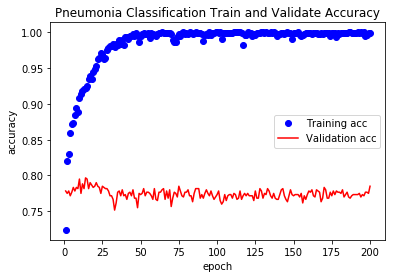

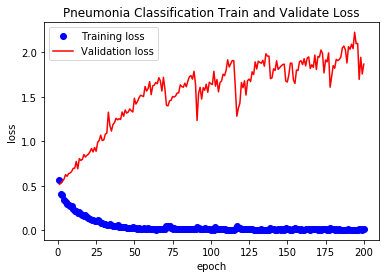

In [55]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.title('Pneumonia Classification Train and Validate Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Pneumonia Classification Train and Validate Loss')
plt.legend()

plt.show()

### Prepare the Test data for Prediction, Confusion Matrix, and Classification Report

In [56]:
# Get predictions
preds = model.predict(test_features, batch_size=20)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(600,)
(600,)


### Confusion Matrix

<Figure size 432x288 with 0 Axes>

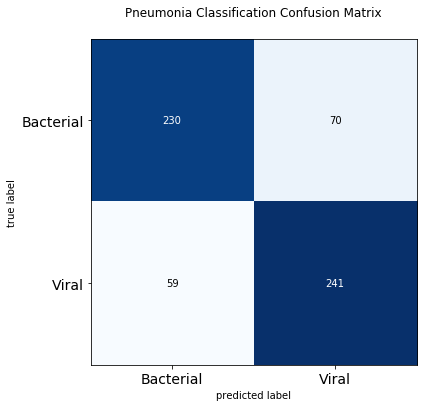

In [57]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,6), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Bacterial', 'Viral'], fontsize=14)
plt.yticks(range(2), ['Bacterial', 'Viral'], fontsize=14)
plt.title('Pneumonia Classification Confusion Matrix')
plt.show()

### Classification Report

In [58]:
print(classification_report(orig_test_labels, preds))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       300
           1       0.77      0.80      0.79       300

   micro avg       0.79      0.79      0.79       600
   macro avg       0.79      0.79      0.78       600
weighted avg       0.79      0.79      0.78       600



In [59]:
# Print the model Loss and Accuracy to compare with previous studies results

score, acc = model.evaluate(test_features, test_labels, batch_size=batch_size)
print('Pneumonia Classification Test loss:', score)
print('Pneumonia Classification Test accuracy:', acc)

600/600 [==============================] - 1s 981us/step
Pneumonia Classification Test loss: 1.8688827772935233
Pneumonia Classification Test accuracy: 0.7850000023841858


From the original study  [Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867418301545%3Fshowall%3Dtrue). 

Both models, Normal vs Pneumonia, and Bacterial Pneumonia vs Viral Pneumonia were adapted using the Inception-v3 architecture pretrained on the ImageNet dataset. The models were trained on an Ubuntu 16.04 computer with 2 Intel Xeon CPUs, using a NVIDIA GTX 1080 8Gb GPU for training and testing, with 256Gb available in RAM memory.

The original study considered 3 metrics. Recall (Sensitivity), Accuracy, and Specifity.

* **`Recall (Sensitivity)`** is the probability that a test will indicate 'disease' among those with the disease. Or,  tp / (tp + fn)
* **`Accuracy`** is the fraction of correctly identified images to the total number of images. Or, (tp + tn) / (tp + tn + fp + fn)
* **`Specificity`** is the fraction of those without disease who will have a negative test result. Or, tn / (tn + fn)


## Discussion








